In [69]:
import jax 
import optax
import haiku as hk
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import NamedTuple, Tuple

In [70]:
INPUT_DIM = 5
HIDDEN_DIM = 2

MAX_STEPS = 10_000
EVAL_PERIOD = 100
BATCH_SIZE = 64
SEED = 42

In [71]:
from typing import Optional

class ToyModel(hk.Module):
    def __init__(self, hidden_dim: int, name: Optional[str] = None):
        super().__init__(name=name)
        self.hidden_dim = hidden_dim

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        j = x.shape[-1] # Input dimension
        w_init = hk.initializers.TruncatedNormal(1. / np.sqrt(j))

        # Get parameters
        W = hk.get_parameter('W', shape=[self.hidden_dim, j], dtype=x.dtype, init=w_init)
        b = hk.get_parameter('b', shape=[j], dtype=x.dtype, init=jnp.ones)

        # Pass input through network
        x = x.T
        x = W.dot(x)
        x = W.T.dot(x)
        x = x.T + b

        return jax.nn.relu(x)

In [72]:
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class Batch(NamedTuple):
    data: jnp.ndarray
    importances: jnp.ndarray

def generate_batch(key: jax.random.KeyArray, batch_size: int, n_features: int, sparsity: float) -> Tuple[Batch, jax.random.KeyArray]:
    key, k1, k2 = jax.random.split(key, 3)
    features = jax.random.uniform(k1, (batch_size, n_features))
    sparsity_mask = jax.random.uniform(k2, (batch_size, n_features)) <= (1 - sparsity)
    data = jnp.where(sparsity_mask, features, 0)
    return Batch(data, jnp.ones(INPUT_DIM)), key

In [74]:
def toy_model_fn(x: jnp.ndarray) -> jnp.ndarray:
    model = ToyModel(hidden_dim=HIDDEN_DIM)
    return model(x)

toy_model = hk.without_apply_rng(hk.transform(toy_model_fn))
optimiser = optax.adam(1e-3)

# Generate feature importances
feature_importances = (0.9**jnp.arange(INPUT_DIM))

def loss_fn(params: hk.Params, batch: Batch) -> jnp.ndarray:
    batch_size, _ = batch.data.shape
    y_hat = toy_model.apply(params, batch.data)

    # L2 reconstruction error
    loss = jnp.sum(feature_importances * (y_hat - batch.data)**2)
    return loss / batch_size

@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    loss, grads = jax.value_and_grad(loss_fn)(state.params, batch)
    updates, opt_state = optimiser.update(grads, state.opt_state)
    params = optax.apply_updates(state.params, updates)
    return TrainingState(params, opt_state), loss

# Get data
key = jax.random.PRNGKey(SEED)
training_batch, key = generate_batch(key, BATCH_SIZE, INPUT_DIM, sparsity=0)


# Initialise weights and optimiser
key, subkey = jax.random.split(key)
initial_params = toy_model.init(subkey, training_batch.data)
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Training loop
pbar = tqdm(range(MAX_STEPS))
for step in pbar:
    training_batch, key = generate_batch(key, BATCH_SIZE, INPUT_DIM, sparsity=0)
    state, loss = update(state, training_batch)

    pbar.set_description(f"Loss: {loss:.3f}")

Loss: 0.199: 100%|██████████| 10000/10000 [00:11<00:00, 895.03it/s]


In [66]:
W = state.params['toy_model']['W']
b = state.params['toy_model']['b']

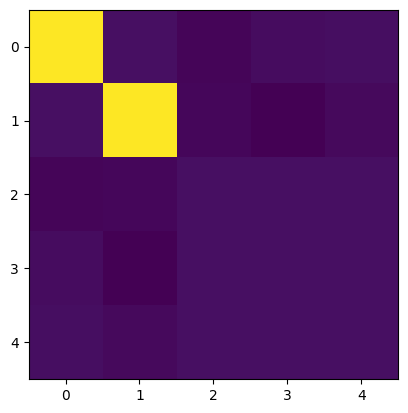

In [67]:
plt.imshow(W.T.dot(W))

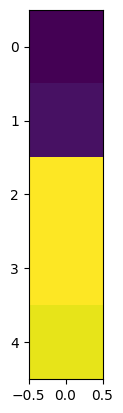

In [68]:
plt.imshow(b[:, None])